In [1]:
import warnings

warnings.filterwarnings('ignore')

warnings.filterwarnings('ignore', category=UserWarning)

warnings.filterwarnings('ignore', category=DeprecationWarning)

warnings.filterwarnings('ignore', message='.*A value is trying to be set on a copy of a slice from a DataFrame.*')

warnings.filterwarnings('ignore', module='statsmodels')

# warnings.filterwarnings('default')

# Web Scraping for New Data

In [2]:
# writing a small function to check if necessary libraries are installed

import pkg_resources
 
def is_package_installed(package_name):
    try:
        pkg_resources.get_distribution(package_name)
        return True
    except pkg_resources.DistributionNotFound:
        return False

In [3]:
if is_package_installed('selenium'):
    print("selenium is installed")
else:
    !pip install selenium

selenium is installed


In [4]:
if is_package_installed('chromedriver-autoinstaller'):
    print("chromedriver-autoinstaller is installed")
else:
    !pip install chromedriver-autoinstaller

chromedriver-autoinstaller is installed


In [5]:
# importing functions needed for webscraping

from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

import sklearn
import chromedriver_autoinstaller
import time
import os

In [6]:
chromedriver_autoinstaller.install()

download_dir = os.getcwd()

options = webdriver.ChromeOptions()
prefs = {
    "safebrowsing.enabled": "true",
    "safebrowsing.disable_download_protection": "true",
    "download.default_directory": download_dir,
    "profile.default_content_setting_values.automatic_downloads": 1,
}

options.add_experimental_option("prefs", prefs)
options.add_argument("--allow-running-insecure-content")
options.add_argument("--ignore-certificate-errors")
options.add_argument("--start-maximized")

# Now initialize the driver with these options
driver = webdriver.Chrome(options=options)

In [7]:
# Navigate to the webpage

driver.get('http://oasis.caiso.com/mrioasis/logon.do')

time.sleep(5)  # waiting for website to load

In [8]:
# Click on System Demand, after checking if the website has loaded. 
# Refresh the page if it has not. 
# (the website sometimes throws a warning when I run the code multiple times)

menu_item_xpath = '//*[@id="LowerMenuItem.oasisMenu.SysDemand"]'

retry_limit = 3
attempts = 0

while attempts < retry_limit:
    try:
        # Try to find and click the System Demand menu item
        menu_item = WebDriverWait(driver, 5).until(
            EC.presence_of_element_located((By.XPATH, menu_item_xpath))
        )
        ActionChains(driver).move_to_element(menu_item).click().perform()
        print("System Demand button found and clicked.")
        break  # Exit loop if successful
    except:
        attempts += 1
        print(f"Attempt {attempts}: System Demand button not found, refreshing page...")
        driver.refresh()
        time.sleep(5) 

if attempts == retry_limit:
    print("Page not loading or System Demand button not found after 3 attempts.")

System Demand button found and clicked.


In [9]:
# Click on Wind and Solar forecast after waiting for the element to be clickable 

try:
    menu_item = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, '//*[@id="DropdownMenu.oasisMenu.SysDemand.windSolar"]'))
    )
    menu_item.click()
except Exception as e:
    print(f"An error occurred: {e}")

In [10]:
# JavaScript to set the dates and dispatch change events
js_script = """
var startDateElement = arguments[0];
var endDateElement = arguments[1];
var startDateValue = arguments[2];
var endDateValue = arguments[3];

startDateElement.value = startDateValue;
endDateElement.value = endDateValue;

function dispatchChangeEvent(element) {
    var event = new Event('change', { bubbles: true });
    element.dispatchEvent(event);
}

dispatchChangeEvent(startDateElement);
dispatchChangeEvent(endDateElement);
"""

In [11]:
# Set the start date and end date (MM/DD/YYYY)
 
start_date = '03/16/2024' 
end_date = '04/08/2024'

In [12]:
# Execute the JavaScript
# running it twice because the start date and end date are the same after the first iteration

time.sleep(2)
for _ in range(2):
    # Find the start and end date input elements by their IDs
    start_date_input = driver.find_element(By.XPATH, '//*[@id="PFC_date_from"]//input')
    end_date_input = driver.find_element(By.XPATH, '//*[@id="PFC_date_to"]//input')  
    #Execute JavaScript
    driver.execute_script(js_script, start_date_input, end_date_input, start_date, end_date)
    time.sleep(2)

In [13]:
# click on apply button

apply_xpath = '//*[@id="ApplyButton"]'
menu_item = WebDriverWait(driver, 5).until(
            EC.presence_of_element_located((By.XPATH, apply_xpath))
        )
ActionChains(driver).move_to_element(menu_item).click().perform()

In [14]:
try:
    # Wait for loading spinner to disappear
    loading_spinner = WebDriverWait(driver, 300).until(
        EC.invisibility_of_element((By.XPATH, '//*[@id="DISPLAY_LOADING_ICON"]'))
    )
    # After the loading spinner is gone, then click the export button
    csv_export_button = driver.find_element(By.XPATH, '//*[@id="CsvExportButton"]')
    csv_export_button.click()
    print("CSV Export button clicked.")

except TimeoutException:
    print("Loading spinner was visible for too long.")

except Exception as e:
    print(f"An unexpected error occurred: {e}")

CSV Export button clicked.


### Please click "Keep" in the chrome test browser download options. Can't bypass safe browsing guardrails of Chrome. Location at top right of browser window. 

Continue once dowload is finished.

In [15]:
driver.quit()

# Loading the data into dataframes

Now we have a zipfile of the required data, we can unzip it and load it to the notebook.

In [16]:
from zipfile import ZipFile

# Find the ZIP file in the directory
zip_file_path = None
for file in os.listdir(download_dir):
    if file.endswith(".zip"):
        zip_file_path = os.path.join(download_dir, file)
        break

if zip_file_path:
    # Extracting the CSV file
    with ZipFile(zip_file_path, 'r') as zip_ref:
        for file_name in zip_ref.namelist():
            if file_name.endswith(".csv"):
                
                temp_extract_path = os.path.join(download_dir, file_name)
                zip_ref.extract(file_name, download_dir)

                new_file_name = f"Wind_Data_new.csv"
                new_file_path = os.path.join(download_dir, new_file_name)

                os.rename(temp_extract_path, new_file_path)
                print(f"Extracted and renamed CSV to: {new_file_path}")

                break  
    
    # Delete the ZIP file after extraction
    os.remove(zip_file_path)
    print(f"Deleted ZIP file: {zip_file_path}")

else:
    print("No ZIP file found in the directory.")

Extracted and renamed CSV to: /Users/rudra/Downloads/2024-04-09 Project Rudra Parikh/Wind_Data_new.csv
Deleted ZIP file: /Users/rudra/Downloads/2024-04-09 Project Rudra Parikh/20240316_20240409_SLD_REN_FCST_N_20240408_20_22_08_v1.zip


In [17]:
# loading all our data into pd dataframes

import pandas as pd

new_csv_name = f"Wind_Data_new.csv"
new_csv_path = os.path.join(download_dir, new_csv_name)

try:
    df_new = pd.read_csv(new_csv_path)
    print("Loaded newly extracted CSV into DataFrame.")
except FileNotFoundError:
    print(f"File not found: {new_csv_path}")

# Paths for the original data
actual_csv_path = os.path.join(download_dir, "Wind_Actual.csv")
forecast_csv_path = os.path.join(download_dir, "Wind_Forecast.csv")

# Load the Wind_Actual.csv into a DataFrame
try:
    df_actual = pd.read_csv(actual_csv_path)
    print("Loaded Wind_Actual.csv into DataFrame.")
except FileNotFoundError:
    print(f"File not found: {actual_csv_path}")

# Load the Wind_Forecast.csv into a DataFrame
try:
    df_forecast = pd.read_csv(forecast_csv_path)
    print("Loaded Wind_Forecast.csv into DataFrame.")
except FileNotFoundError:
    print(f"File not found: {forecast_csv_path}")


Loaded newly extracted CSV into DataFrame.
Loaded Wind_Actual.csv into DataFrame.
Loaded Wind_Forecast.csv into DataFrame.


In [18]:
df_actual.tail()

,DATE,HE,Trading_Hub,Renewable_Type,MW
10531,2024-03-15,20,SP15,Wind,101.05175
10532,2024-03-15,21,SP15,Wind,71.24899
10533,2024-03-15,22,SP15,Wind,176.70400
10534,2024-03-15,23,SP15,Wind,127.64309
10535,2024-03-15,24,SP15,Wind,51.58621


In [19]:
# filtering for columns we need

df_new = df_new[['OPR_DT', 'OPR_HR', 'TRADING_HUB', 'RENEWABLE_TYPE', 'MW', 'MARKET_RUN_ID']]
df_new.columns = ['DATE', 'HE', 'Trading_Hub', 'Renewable_Type', 'MW', 'type_of_data']
df_new.head()

,DATE,HE,Trading_Hub,Renewable_Type,MW,type_of_data
0,2024-03-16,14,NP15,Solar,1325.09824,ACTUAL
1,2024-03-16,1,NP15,Solar,-4.54895,ACTUAL
2,2024-03-16,15,NP15,Solar,1303.29227,ACTUAL
3,2024-03-16,10,NP15,Solar,1465.25906,ACTUAL
4,2024-03-16,16,NP15,Solar,1369.17897,ACTUAL


In [20]:
# filtering further for the data we need

df_new = df_new[(df_new['Trading_Hub'] == 'SP15') & 
                              (df_new['Renewable_Type'] == 'Wind')]

#dividing new data into actual and forecast, dropping unneeded column, sorting data

df_new_actual = df_new[df_new['type_of_data'] == 'ACTUAL'].drop(columns=['type_of_data']).sort_values(by=['DATE', 'HE'])
df_new_forecast = df_new[df_new['type_of_data'] == 'DAM'].drop(columns=['type_of_data']).sort_values(by=['DATE', 'HE'])

In [21]:
# appending the new data

df_actual = pd.concat([df_actual, df_new_actual]).reset_index(drop=True)

df_forecast = pd.concat([df_forecast, df_new_forecast]).reset_index(drop=True)

df_actual, df_forecast

(             DATE  HE Trading_Hub Renewable_Type          MW
 0      2023-01-01   1        SP15           Wind  2108.04570
 1      2023-01-01   2        SP15           Wind  2563.03702
 2      2023-01-01   3        SP15           Wind  2799.13237
 3      2023-01-01   4        SP15           Wind  2659.33710
 4      2023-01-01   5        SP15           Wind  2224.13754
 ...           ...  ..         ...            ...         ...
 11099  2024-04-08  16        SP15           Wind   945.14156
 11100  2024-04-08  17        SP15           Wind  1317.95540
 11101  2024-04-08  18        SP15           Wind  1506.39283
 11102  2024-04-08  19        SP15           Wind  1752.77876
 11103  2024-04-08  20        SP15           Wind  1629.37711
 
 [11104 rows x 5 columns],
              DATE  HE Trading_Hub Renewable_Type       MW
 0      2023-01-01   1        SP15           Wind  2474.02
 1      2023-01-01   2        SP15           Wind  2581.14
 2      2023-01-01   3        SP15           Wind 

In [22]:
# need to drop last day's data from actual as that 
# would not be available if we are making predictions for tomorrow

df_actual = df_actual[df_actual['DATE'] != '2024-04-08']
df_actual.tail()

,DATE,HE,Trading_Hub,Renewable_Type,MW
11079,2024-04-07,20,SP15,Wind,3279.53793
11080,2024-04-07,21,SP15,Wind,3348.21790
11081,2024-04-07,22,SP15,Wind,3303.01853
11082,2024-04-07,23,SP15,Wind,3202.79313
11083,2024-04-07,24,SP15,Wind,3229.76742


# Exploratory Data Analysis

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import statsmodels

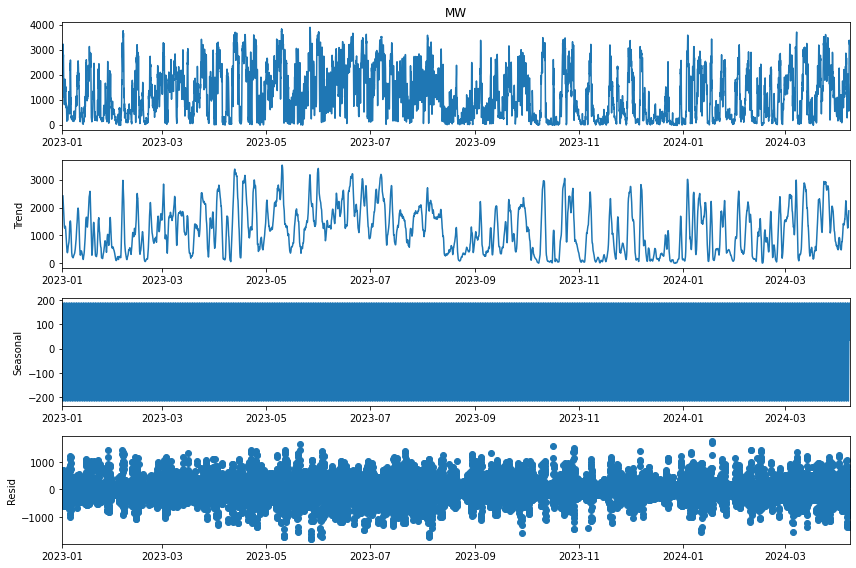

In [24]:
# time series decomposition
# creating a datetime index
from statsmodels.tsa.seasonal import seasonal_decompose

df_actual['DATETIME'] = pd.to_datetime(df_actual['DATE']) + pd.to_timedelta(df_actual['HE'] - 1, unit='h')
df_actual.set_index('DATETIME', inplace=True)

time_series = df_actual['MW']

# setting frequency 24 to look at daily patterns
result = seasonal_decompose(time_series, model='additive', period=24)

plt.rcParams['figure.figsize'] = [12, 8]
result.plot()
plt.show()

There does not seem to be any trend or seasonality in the time series, let's look at the last 2 months for a better view.

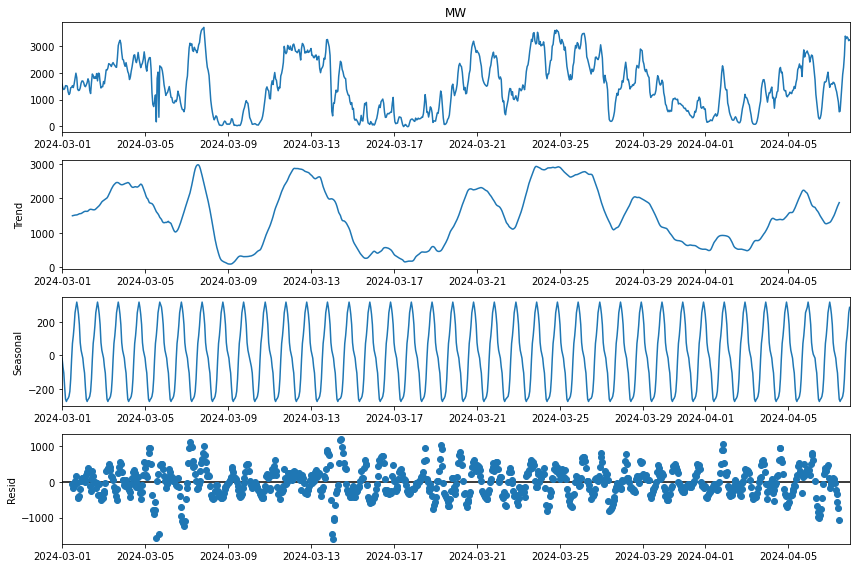

In [25]:
time_series_2m = df_actual['MW'].last('2M')

# setting frequency 24 to look at daily patterns
result = seasonal_decompose(time_series_2m, model='additive', period=24)

plt.rcParams['figure.figsize'] = [12, 8]
result.plot()
plt.show()

Trend and residuals look random, but now there is a clear seasonal component for each day. Let's look at the decomposition for power generated at hour ending at noon.

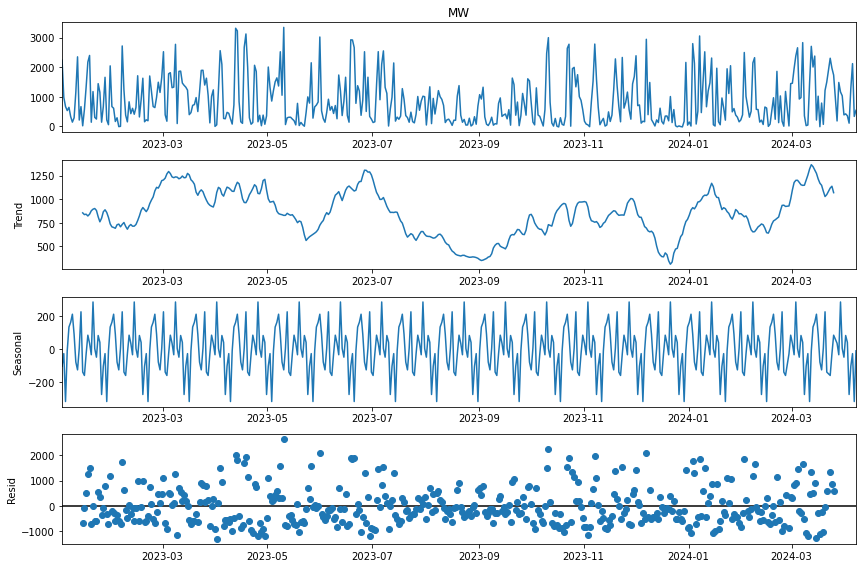

In [26]:
time_series_12h = df_actual[(df_actual['HE'] == 12)]['MW']

# setting frequency 30 to look at monthly patterns
result = seasonal_decompose(time_series_12h, model='additive', period=24)

plt.rcParams['figure.figsize'] = [12, 8]
result.plot()
plt.show()

Again, we can see seasonality without any significant trend.

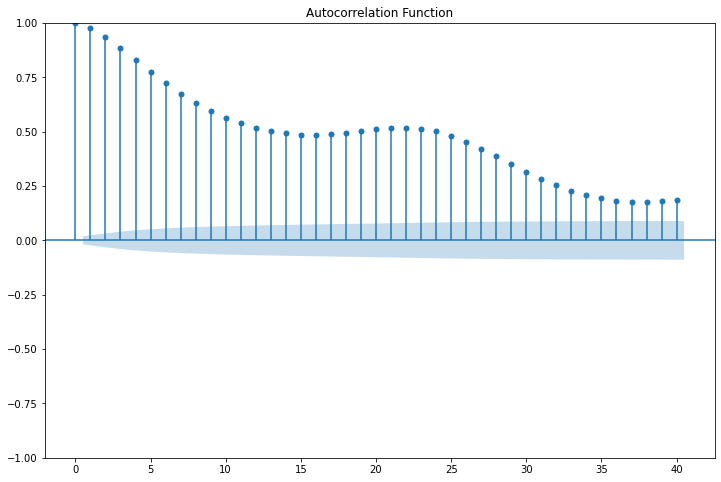

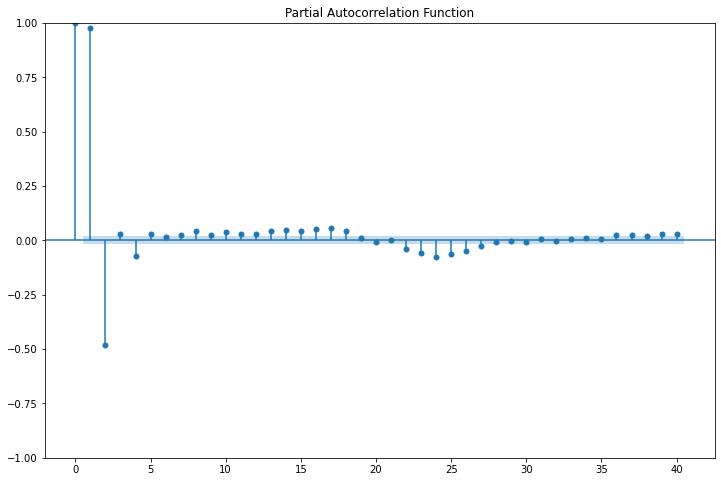

ADF Statistic: -10.19710919419152
p-value: 6.1053765404379065e-18
Critical Value (1%): -3.4309422510477696
Critical Value (5%): -2.8618017424577933
Critical Value (10%): -2.566909320386296
The series is stationary.


In [27]:
# Performing Autocorrelation, Partial Autocorrelation, and Stationarity Tests

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Autocorrelation Function (ACF)
plot_acf(df_actual['MW'], lags=40, title='Autocorrelation Function')
plt.show()

# Partial Autocorrelation Function (PACF)
plot_pacf(df_actual['MW'], lags=40, title='Partial Autocorrelation Function')
plt.show()

# Augmented Dickey-Fuller test for Stationarity
adf_test = adfuller(df_actual['MW'])

print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
for key, value in adf_test[4].items():
    print(f'Critical Value ({key}): {value}')

# Interpreting the ADF test
if adf_test[1] > 0.05:
    print("The series is not stationary. Consider differencing or transformation.")
else:
    print("The series is stationary.")

Let's also do the same for the last 2 months.

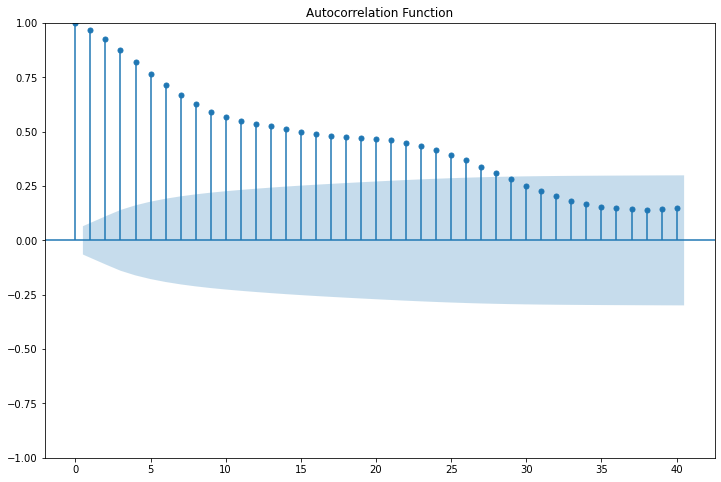

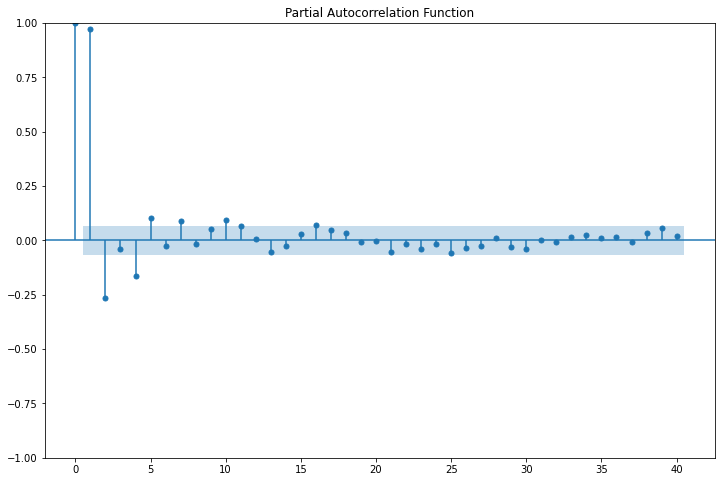

ADF Statistic: -3.551145524327538
p-value: 0.006766716688580012
Critical Value (1%): -3.4376857669714957
Critical Value (5%): -2.864778351359889
Critical Value (10%): -2.5684943199755765
The series is stationary.


In [28]:
# Autocorrelation Function (ACF)
plot_acf(df_actual['MW'].last('2M'), lags=40, title='Autocorrelation Function')
plt.show()

# Partial Autocorrelation Function (PACF)
plot_pacf(df_actual['MW'].last('2M'), lags=40, title='Partial Autocorrelation Function')
plt.show()

# Augmented Dickey-Fuller test for Stationarity
adf_test = adfuller(df_actual['MW'].last('2M'))

print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
for key, value in adf_test[4].items():
    print(f'Critical Value ({key}): {value}')

# Interpreting the ADF test
if adf_test[1] > 0.05:
    print("The series is not stationary. Consider differencing or transformation.")
else:
    print("The series is stationary.")

This stationarity means that the time series does not exhibit trends or seasonality that change over time, making it suitable for modeling without needing to apply differencing or transformations to stabilize the mean.

Let's do ACF PACF tests for hour ending at 12

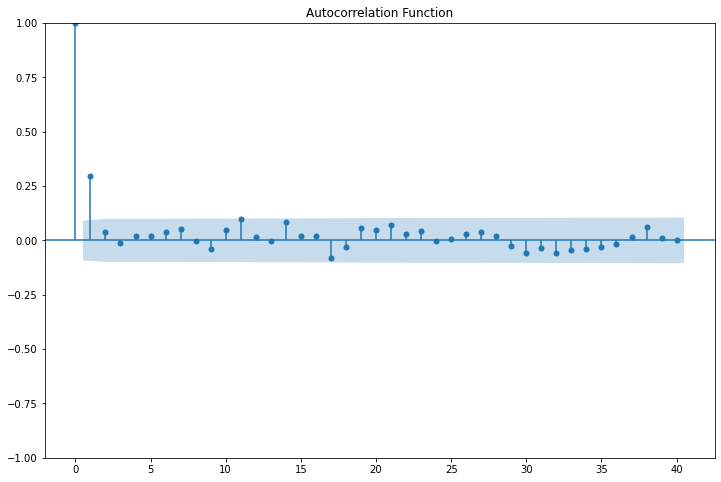

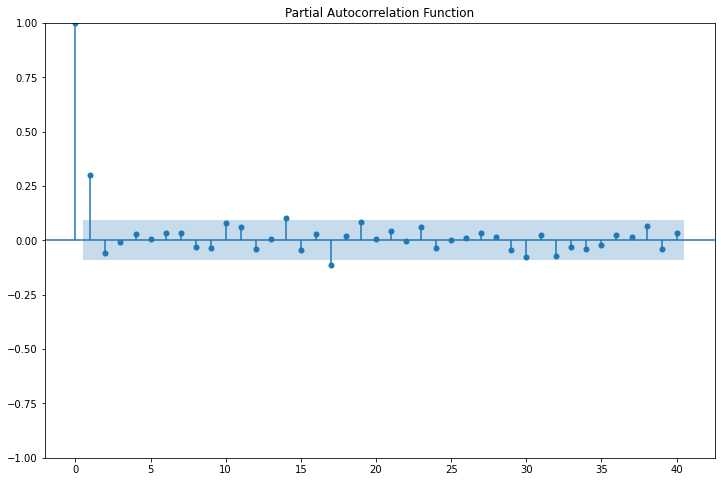

ADF Statistic: -15.76969709107279
p-value: 1.1649900818365854e-28
Critical Value (1%): -3.4446773373329576
Critical Value (5%): -2.8678574606780654
Critical Value (10%): -2.5701349669405404
The series is stationary.


In [29]:
# Autocorrelation Function (ACF)
df_temp = df_actual[(df_actual['HE'] == 12)]['MW']
plot_acf(df_temp, lags=40, title='Autocorrelation Function')
plt.show()

# Partial Autocorrelation Function (PACF)
plot_pacf(df_temp, lags=40, title='Partial Autocorrelation Function')
plt.show()

# Augmented Dickey-Fuller test for Stationarity
adf_test = adfuller(df_temp)

print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
for key, value in adf_test[4].items():
    print(f'Critical Value ({key}): {value}')

# Interpreting the ADF test
if adf_test[1] > 0.05:
    print("The series is not stationary. Consider differencing or transformation.")
else:
    print("The series is stationary.")

In [30]:
df_forecast['DATETIME'] = pd.to_datetime(df_forecast['DATE']) + pd.to_timedelta(df_forecast['HE'] - 1, unit='h')
df_forecast.set_index('DATETIME', inplace=True)

Let's look at the correlation between actual and forecast values.

In [31]:
df_merged = pd.merge(df_actual, df_forecast['MW'], on=['DATETIME'], suffixes=('', '_forecast'))

corr = round(df_merged['MW'].corr(df_merged['MW_forecast']), 3)
print(f"Correlation between actual and forecasted values: {corr}")

Correlation between actual and forecasted values: 0.73


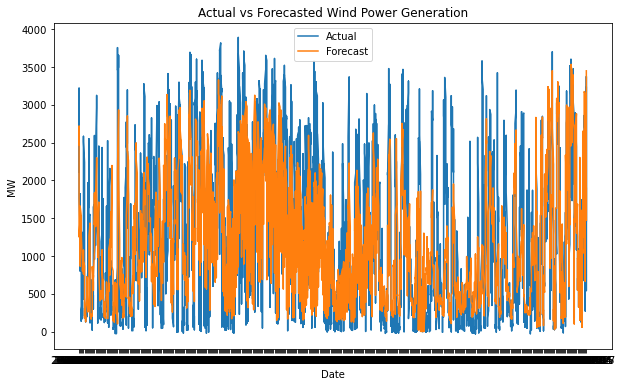

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(df_merged['DATE'], df_merged['MW'], label='Actual')
plt.plot(df_merged['DATE'], df_merged['MW_forecast'], label='Forecast')
plt.xlabel('Date')
plt.ylabel('MW')
plt.title('Actual vs Forecasted Wind Power Generation')
plt.legend()
plt.show()

Correlation of 0.73 implies that forecast time series have good predictive information and we should use them as a feature.

It's clear that ARIMA would be a good approach. We can adjust for daily seasonality, and add exogenous variables like month and forecast data. SARIMAX model is ideal.

In [33]:
# I want to use day 1's forecast data, actual data from day 0, -1, -2... to predict day 2
# need to shift forecast data to align with day 0
df_forecast.shift(-24)

,DATE,HE,Trading_Hub,Renewable_Type,MW
DATETIME,,,,,
2023-01-01 00:00:00,2023-01-02,1.0,SP15,Wind,1510.76
2023-01-01 01:00:00,2023-01-02,2.0,SP15,Wind,1379.49
2023-01-01 02:00:00,2023-01-02,3.0,SP15,Wind,1245.48
2023-01-01 03:00:00,2023-01-02,4.0,SP15,Wind,1114.74
2023-01-01 04:00:00,2023-01-02,5.0,SP15,Wind,1098.44
...,...,...,...,...,...
2024-04-08 19:00:00,NaN,NaN,NaN,NaN,NaN
2024-04-08 20:00:00,NaN,NaN,NaN,NaN,NaN
2024-04-08 21:00:00,NaN,NaN,NaN,NaN,NaN


In [34]:
df_merged = pd.merge(df_actual, df_forecast['MW'].shift(-24), on=['DATETIME'], suffixes=('', '_forecast'))
df_merged['MW_forecast'] = df_merged['MW_forecast'].fillna(method = 'ffill') # filling any missing values

df_merged['month'] = df_merged.index.month # I want month to be an exogenous feature

df_merged =  df_merged.reset_index() # resetting to numerical index after merging

df_merged

,DATETIME,DATE,HE,Trading_Hub,Renewable_Type,MW,MW_forecast,month
0,2023-01-01 00:00:00,2023-01-01,1,SP15,Wind,2108.04570,1510.76,1
1,2023-01-01 01:00:00,2023-01-01,2,SP15,Wind,2563.03702,1379.49,1
2,2023-01-01 02:00:00,2023-01-01,3,SP15,Wind,2799.13237,1245.48,1
3,2023-01-01 03:00:00,2023-01-01,4,SP15,Wind,2659.33710,1114.74,1
4,2023-01-01 04:00:00,2023-01-01,5,SP15,Wind,2224.13754,1098.44,1
...,...,...,...,...,...,...,...,...
10843,2024-04-07 19:00:00,2024-04-07,20,SP15,Wind,3279.53793,1845.51,4
10844,2024-04-07 20:00:00,2024-04-07,21,SP15,Wind,3348.21790,1792.07,4
10845,2024-04-07 21:00:00,2024-04-07,22,SP15,Wind,3303.01853,1637.19,4
10846,2024-04-07 22:00:00,2024-04-07,23,SP15,Wind,3202.79313,1423.15,4


Now, I want to predict each hour for 9th April using SARIMAX. I will test for HE=12 first, its ACF PACF tests suggests a (0, 1, 0) ARIMA would be appropriate.

In [35]:
df_hour12 = df_merged[(df_merged['HE'] == 12)]
df_hour12 = df_hour12.reset_index()

# Split data: 70% train, 15% validation, 15% test
n = len(df_hour12)
train_df = df_hour12.iloc[:int(n*0.7)]
validate_df = df_hour12.iloc[int(n*0.7):int(n*0.85)]
test_df = df_hour12.iloc[int(n*0.85):]

endog_train = train_df['MW'] # endogenous feature
exog_train = train_df[['MW_forecast', 'month']] # exogenous features

endog_validate = validate_df['MW']
exog_validate = validate_df[['MW_forecast', 'month']]

endog_test = test_df['MW']
exog_test = test_df[['MW_forecast', 'month']]

Now, we can tune hyperparameters using grid search for the SARIMAX over the validation set to minimize RMSE.

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [37]:
'''
from itertools import product

# Define ranges for each parameter
p_range = d_range = q_range = range(0, 2)  
P_range = D_range = Q_range = range(0, 2)
s = 30  # seasonal period of one month noticed for each hour data

# Prepare lists to store results
best_rmse = float('inf')
best_params = None

# Grid search
for params in product(p_range, d_range, q_range, P_range, D_range, Q_range):
    p, d, q, P, D, Q = params
    
    try:
        model = SARIMAX(endog_train, exog=exog_train,
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, s),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        results = model.fit(disp=False)

        # Forecast and evaluate
        forecast = results.get_forecast(steps=len(validate_df), exog=exog_validate)
        forecast_mean = forecast.predicted_mean
        rmse = mean_squared_error(endog_validate, forecast_mean, squared=False)

        # Update best params
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params

        print(f'Tested {params}, RMSE: {rmse}')

    except Exception as e:
        print(f'Error with params {params}: {e}')
        continue

print(f'Best parameters: {best_params}, Validation RMSE: {best_rmse}')
'''

Tested (0, 0, 0, 0, 0, 0), RMSE: 882.0774910284737
Tested (0, 0, 0, 0, 0, 1), RMSE: 882.8434759159034
Tested (0, 0, 0, 0, 1, 0), RMSE: 1231.6954803874933
Tested (0, 0, 0, 0, 1, 1), RMSE: 871.4534763540514
Tested (0, 0, 0, 1, 0, 0), RMSE: 882.922964528095
Tested (0, 0, 0, 1, 0, 1), RMSE: 882.5275887421783
Tested (0, 0, 0, 1, 1, 0), RMSE: 1049.896654729123
Tested (0, 0, 0, 1, 1, 1), RMSE: 873.7145992683267
Tested (0, 0, 1, 0, 0, 0), RMSE: 886.1867619436449
Tested (0, 0, 1, 0, 0, 1), RMSE: 887.6764597996795
Tested (0, 0, 1, 0, 1, 0), RMSE: 1218.6316948261876
Tested (0, 0, 1, 0, 1, 1), RMSE: 863.0159349555472
Tested (0, 0, 1, 1, 0, 0), RMSE: 887.8439858535675
Tested (0, 0, 1, 1, 0, 1), RMSE: 887.6502976258515
Tested (0, 0, 1, 1, 1, 0), RMSE: 1031.9115424313568
Tested (0, 0, 1, 1, 1, 1), RMSE: 864.4697980717308
Tested (0, 1, 0, 0, 0, 0), RMSE: 1645.1352093631608
Tested (0, 1, 0, 0, 0, 1), RMSE: 1624.010062023691
Tested (0, 1, 0, 0, 1, 0), RMSE: 1826.2710491605899
Tested (0, 1, 0, 0, 1, 1), 

/Users/rudra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested (0, 1, 1, 1, 0, 1), RMSE: 847.3514055648575
Tested (0, 1, 1, 1, 1, 0), RMSE: 1691.1159812477556
Tested (0, 1, 1, 1, 1, 1), RMSE: 1589.9878743150307
Tested (1, 0, 0, 0, 0, 0), RMSE: 887.8957809017105
Tested (1, 0, 0, 0, 0, 1), RMSE: 889.7397390275975
Tested (1, 0, 0, 0, 1, 0), RMSE: 1219.1870913224363
Tested (1, 0, 0, 0, 1, 1), RMSE: 862.6777370257846
Tested (1, 0, 0, 1, 0, 0), RMSE: 889.7928833628348
Tested (1, 0, 0, 1, 0, 1), RMSE: 889.8484818880138
Tested (1, 0, 0, 1, 1, 0), RMSE: 1035.2823765715698
Tested (1, 0, 0, 1, 1, 1), RMSE: 864.5631002427062
Tested (1, 0, 1, 0, 0, 0), RMSE: 884.95515552382
Tested (1, 0, 1, 0, 0, 1), RMSE: 886.7509849710641
Tested (1, 0, 1, 0, 1, 0), RMSE: 1219.5274988035878


/Users/rudra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested (1, 0, 1, 0, 1, 1), RMSE: 863.2777340727663
Tested (1, 0, 1, 1, 0, 0), RMSE: 886.7843830461801
Tested (1, 0, 1, 1, 0, 1), RMSE: 886.7546260329079
Tested (1, 0, 1, 1, 1, 0), RMSE: 1035.6116186309778


/Users/rudra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested (1, 0, 1, 1, 1, 1), RMSE: 864.8120167649355
Tested (1, 1, 0, 0, 0, 0), RMSE: 1520.555436233443
Tested (1, 1, 0, 0, 0, 1), RMSE: 1500.9965479585203
Tested (1, 1, 0, 0, 1, 0), RMSE: 1623.9811659027268
Tested (1, 1, 0, 0, 1, 1), RMSE: 1475.775351707449
Tested (1, 1, 0, 1, 0, 0), RMSE: 1505.146232868399
Tested (1, 1, 0, 1, 0, 1), RMSE: 1492.7891498540403
Tested (1, 1, 0, 1, 1, 0), RMSE: 1424.3927237480605
Tested (1, 1, 0, 1, 1, 1), RMSE: 1477.1265794357669
Tested (1, 1, 1, 0, 0, 0), RMSE: 1407.004547613728
Tested (1, 1, 1, 0, 0, 1), RMSE: 1205.877069786655
Tested (1, 1, 1, 0, 1, 0), RMSE: 1829.9164985124635
Tested (1, 1, 1, 0, 1, 1), RMSE: 1624.0041222029356


/Users/rudra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested (1, 1, 1, 1, 0, 0), RMSE: 834.9989920443845


/Users/rudra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested (1, 1, 1, 1, 0, 1), RMSE: 986.2175362093153
Tested (1, 1, 1, 1, 1, 0), RMSE: 1688.141479548124
Tested (1, 1, 1, 1, 1, 1), RMSE: 1621.6485051954623
Best parameters: (1, 1, 1, 1, 0, 0), Validation RMSE: 834.9989920443845


Now, we can test the model for hour 12.

In [38]:
best_params = (1, 1, 1, 1, 0, 0) # from hyperparameter tuning
(p, d, q, P, D, Q) = best_params
s = 30

# Combine the training and validation sets for hour=12
n = len(df_hour12)
train_validate_df = df_hour12.iloc[:int(n*0.85)]  # Using the first 85% of data as train+validate
test_df = df_hour12.iloc[int(n*0.85):]  # The last 15% as test

endog_train_validate = train_validate_df['MW']
exog_train_validate = train_validate_df[['MW_forecast', 'month']]

endog_test = test_df['MW']
exog_test = test_df[['MW_forecast', 'month']]

# Fit the SARIMAX model with the best parameters
model = SARIMAX(endog_train_validate,
                exog=exog_train_validate,
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)

# Forecast on the test set
forecast = results.get_forecast(steps=len(test_df), exog=exog_test)
predicted_mean = forecast.predicted_mean

# Calculate RMSE for the test set
rmse_test = np.sqrt(mean_squared_error(endog_test, predicted_mean))
print(f'Test RMSE for hour 12 with best parameters: {rmse_test}')

/Users/rudra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test RMSE for hour 12 with best parameters: 801.750683110829


Now we can use these parameters to train over each hour and make predictions for 9th April, 2 steps into the future.

In [43]:
import joblib
models_dir = download_dir + "/models/"

# Initialize a dictionary to store the 2-step forecast results for each hour
hourly_forecasts = {}

(p, d, q, P, D, Q) = best_params
s = 30  

# Loop through each hour of the day
for hour in range(24):
    df_hourly = df_merged[(df_merged['HE'] == hour + 1)]

    if not df_hourly.empty:
        endog = df_hourly['MW']
        exog = df_hourly[['MW_forecast', 'month']]

        # Prepare exog data for forecasting the next 2 steps
        exog_future = pd.concat([exog[-1:].reset_index(drop=True)]*2, ignore_index=True)

        # Fit the SARIMAX model
        #model = SARIMAX(endog, exog=exog, order=(p, d, q), seasonal_order=(P, D, Q, s), enforce_stationarity=False, enforce_invertibility=False)
        #results = model.fit(disp=False)
        
        # Save the model
        #model_filename = f'{models_dir}sarimax_model_hour_{hour + 1}.pkl'
        #joblib.dump(results, model_filename)
        
        # Load the model
        model_filename = f'{models_dir}sarimax_model_hour_{hour + 1}.pkl'
        results = joblib.load(model_filename)

        # Forecast the next 2 steps with the future exogenous data
        forecast = results.get_forecast(steps=2, exog=exog_future)
        predicted_mean = forecast.predicted_mean

        # Store the 2-step forecast results, only interested in the second forecast
        hourly_forecasts[hour + 1] = predicted_mean.iloc[1]

# Convert the hourly forecast results to a DataFrame for easier handling
df_hourly_forecasts = pd.DataFrame(list(hourly_forecasts.items()), columns=['Hour', 'Forecast_April_9'])
df_hourly_forecasts

/Users/rudra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/rudra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/rudra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/rudra/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Use

,Hour,Forecast_April_9
0,1,1894.857230
1,2,2275.371486
2,3,2208.141041
3,4,2182.127821
4,5,2179.105254
5,6,2065.697484
6,7,1739.439997
7,8,1489.218487
8,9,1213.488266
9,10,907.823971


In [44]:
df_forecasts = pd.DataFrame({
    'DATE': [(end_date)] * 24 ,
    'HE': df_hourly_forecasts['Hour'],
    'Trading_Hub': ['SP15'] * 24,
    'Renewable_Type': ['Wind'] * 24,
    'MW': df_hourly_forecasts['Forecast_April_9'] 
})

In [45]:
# Write the DataFrame to a CSV file

df_forecasts.to_csv(os.path.join(download_dir, 'Wind_Forecast_2024_04_09.csv'), index=False)